# Recommendation System
**Data from Netflix**

*   combine_data_*.txt - This text file contains movie_id, customer_id, rating, date
*   movie_titles.csv - This CSV file contains movie_id and movie_title

**Import Packages**

In [3]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

# Load Data

*   combine_data_*.txt :- Read from this file. This is a comma separated file. It includes movie_id, customer_id, rating and date
*   netflix_rating.csv :- This is a csv file generated by reading from the combine_data_*.txt file

In [4]:
def load_data():
    netflix_csv_file = open("netflix_rating.csv", mode = "w")
    rating_files = ['NetflixPrizeData/combined_data_1.txt','NetflixPrizeData/combined_data_2.txt','NetflixPrizeData/combined_data_3.txt','NetflixPrizeData/combined_data_4.txt'] 
    for file in rating_files:
        with open(file) as f:
            for line in f:
                line = line.strip()
                if line.endswith(":"):
                    movie_id = line.replace(":", "")
                else:
                    row_data = []
                    row_data = [item for item in line.split(",")]
                    row_data.insert(0, movie_id)
                    netflix_csv_file.write(",".join(row_data))  
                    netflix_csv_file.write('\n')
                    
    netflix_csv_file.close()
    df = pd.read_csv('netflix_rating.csv', sep=",", names = ["movie_id","customer_id", "rating", "date"])
    return df

**Display Netflix Rating Data**

In [5]:
netflix_rating_df = load_data()
netflix_rating_df
netflix_rating_df.head()

,movie_id,customer_id,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


**Check for the duplicate records**

In [6]:
netflix_rating_df.duplicated(["movie_id","customer_id", "rating", "date"]).sum()

0

# Split Data into Train and Test Data

*   train_data = 80%
*   test_data = 20%


In [7]:
split_value = int(len(netflix_rating_df) * 0.80)
train_data = netflix_rating_df[:split_value]
test_data = netflix_rating_df[split_value:]

# Analysis of Data

Count of Ratings - 1, 2, 3, 4, 5

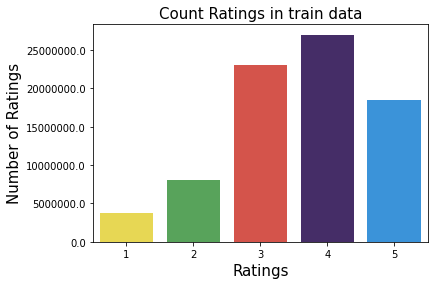

In [8]:
plt.figure(figsize = (6, 4))
ax = sns.countplot(x="rating", data=train_data, palette=['#ffeb3b',"#4caf50","#eb4034",'#432371','#2196f3'])
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 10)
plt.title("Count Ratings in train data", fontsize = 15)
plt.xlabel("Ratings", fontsize = 15)
plt.ylabel("Number of Ratings", fontsize = 15)
plt.show()

# Create User-Item Sparse Matrix

In User-Item sparse matrix, items' values are present in the column and users' values are present in the rows. The rating of the user is present in the cell.

In [9]:
def get_user_item_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df.rating, (df.customer_id, df.movie_id)))
    return sparse_data

**Create Sparse Matrix from the Training Dataset**

In [10]:
train_sparse_data = get_user_item_sparse_matrix(train_data)

**Create Sparse Matrix from the Test Dataset**

In [11]:
test_sparse_data = get_user_item_sparse_matrix(test_data)

**Find Average Gloabal Rating of Movie**

In [12]:
global_average_rating = train_sparse_data.sum()/train_sparse_data.count_nonzero()
print("Global Average Rating: {}".format(global_average_rating))

Global Average Rating: 3.602850901241354


**A Generic Method to Calculate Average Rating from Sparse Matrix**

In [13]:
def get_average_rating(sparse_matrix, is_user):
    ax = 1 if is_user else 0
    sum_of_ratings = sparse_matrix.sum(axis = ax).A1  
    no_of_ratings = (sparse_matrix != 0).sum(axis = ax).A1 
    rows, cols = sparse_matrix.shape
    average_ratings = {i: sum_of_ratings[i]/no_of_ratings[i] for i in range(rows if is_user else cols) if no_of_ratings[i] != 0}
    return average_ratings

**Calculate Average User Rating**

In [14]:
average_rating_user = get_average_rating(train_sparse_data, True)

**Calcualte Average Movie Rating**

In [15]:
avg_rating_movie = get_average_rating(train_sparse_data, False)

# Check Cold Start Problem for Users

Here, there are about 1% of new users and they have no rating available. This can lead to a cold start problem.

In [16]:
total_users = len(np.unique(netflix_rating_df["customer_id"]))
train_users = len(average_rating_user)
uncommonUsers = total_users - train_users
                  
print("Total no. of Users = {}".format(total_users))
print("No. of Users in train data= {}".format(train_users))
print("No. of Users not present in train data = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total no. of Users = 480189
No. of Users in train data= 479670
No. of Users not present in train data = 519(0.0%)


# Check Cold Start Problem for the Movies

Here, about 19% of total movies are new and their rating might not be available in the dataset.

In [17]:
total_movies = len(np.unique(netflix_rating_df["movie_id"]))
train_movies = len(avg_rating_movie)
uncommonMovies = total_movies - train_movies
                  
print("Total no. of Movies = {}".format(total_movies))
print("No. of Movies in train data= {}".format(train_movies))
print("No. of Movies not present in train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total no. of Movies = 17770
No. of Movies in train data= 14482
No. of Movies not present in train data = 3288(19.0%)


# Computation of user similarity to find similarities of top 100 users

In [18]:
def compute_user_similarity(sparse_matrix, limit=100):
    row_index, col_index = sparse_matrix.nonzero()
    rows = np.unique(row_index)
    similar_arr = np.zeros(61700).reshape(617,100)
    
    for row in rows[:limit]:
        sim = cosine_similarity(sparse_matrix.getrow(row), train_sparse_data).ravel()
        similar_indices = sim.argsort()[-limit:]
        similar = sim[similar_indices]
        similar_arr[row] = similar
    
    return similar_arr

In [19]:
similar_user_matrix = compute_user_similarity(train_sparse_data, 100)

In [20]:
similar_user_matrix[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Load Movie Titles

In [21]:
movie_titles_df = pd.read_csv('NetflixPrizeData/movie_titles2.csv', encoding = "ISO-8859-1", sep = ",", header = None, names = ['Movie_Id', 'Year', 'Name'],usecols = [0,1,2])
movie_titles_df.set_index('Movie_Id', inplace = True)
movie_titles_df.head()

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


# Compute Movie Similarity Matrix

In [22]:
def compute_movie_similarity_count(sparse_matrix, movie_titles_df, movie_id):
    similarity = cosine_similarity(sparse_matrix.T, dense_output = False)
    no_of_similar_movies = movie_titles_df.loc[movie_id][1], similarity[movie_id].count_nonzero()
    return no_of_similar_movies

In [23]:
similar_movies = compute_movie_similarity_count(train_sparse_data, movie_titles_df, 1775)
print("Similar Movies = {}".format(similar_movies))

Similar Movies = ('Dario Argento Collection: Vol. 1: Phenomena', 14473)


# Create Sample Sparse Matrix

This method will be used to generate Sample Sparse Matrix. New similarity features will be generated from this sample sparse matrix.

In [24]:
def get_sample_sparse_matrix(sparse_matrix, no_of_users, no_of_movies):
    users, movies, ratings = sparse.find(sparse_matrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15) 
    user = np.random.choice(uniq_users, no_of_users, replace = False)
    movie = np.random.choice(uniq_movies, no_of_movies, replace = True)
    mask = np.logical_and(np.isin(users, user), np.isin(movies, movie))
    sparse_matrix = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), 
                                                     shape = (max(user)+1, max(movie)+1))
    return sparse_matrix

**Sample Sparse Matrix for the Traning Data**

In [25]:
train_sample_sparse_matrix = get_sample_sparse_matrix(train_sparse_data, 400, 40)

**Sample Sparse Matrix for the Test Data**

In [26]:
test_sparse_matrix_matrix = get_sample_sparse_matrix(test_sparse_data, 200, 20)

# A Generic Method to Generate Similar Features.

This will generate below similar features:

*   similar_user_rating1
*   similar_user_rating2
*   similar_user_rating3
*   similar_user_rating4
*   similar_user_rating5
*   similar_movie_rating1
*   similar_movie_rating2
*   similar_movie_rating3
*   similar_movie_rating4
*   similar_movie_rating5











In [27]:
def create_new_similar_features(sample_sparse_matrix):
    global_avg_rating = get_average_rating(sample_sparse_matrix, False)
    global_avg_users = get_average_rating(sample_sparse_matrix, True)
    global_avg_movies = get_average_rating(sample_sparse_matrix, False)
    sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_sparse_matrix)
    new_features_csv_file = open("new_features.csv", mode = "w")
    
    for user, movie, rating in zip(sample_train_users, sample_train_movies, sample_train_ratings):
        similar_arr = list()
        similar_arr.append(user)
        similar_arr.append(movie)
        similar_arr.append(sample_sparse_matrix.sum()/sample_sparse_matrix.count_nonzero())
        
        similar_users = cosine_similarity(sample_sparse_matrix[user], sample_sparse_matrix).ravel()
        indices = np.argsort(-similar_users)[1:]
        ratings = sample_sparse_matrix[indices, movie].toarray().ravel()
        top_similar_user_ratings = list(ratings[ratings != 0][:5])
        top_similar_user_ratings.extend([global_avg_rating[movie]] * (5 - len(ratings)))
        similar_arr.extend(top_similar_user_ratings)
        
        similar_movies = cosine_similarity(sample_sparse_matrix[:,movie].T, sample_sparse_matrix.T).ravel()
        similar_movies_indices = np.argsort(-similar_movies)[1:]
        similar_movies_ratings = sample_sparse_matrix[user, similar_movies_indices].toarray().ravel()
        top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
        top_similar_movie_ratings.extend([global_avg_users[user]] * (5-len(top_similar_movie_ratings)))
        similar_arr.extend(top_similar_movie_ratings)
        
        similar_arr.append(global_avg_users[user])
        similar_arr.append(global_avg_movies[movie])
        similar_arr.append(rating)
        
        new_features_csv_file.write(",".join(map(str, similar_arr)))
        new_features_csv_file.write("\n")
        
    new_features_csv_file.close()
    new_features_df = pd.read_csv('new_features.csv', names = ["user_id", "movie_id", "gloabl_average", "similar_user_rating1", "similar_user_rating2", "similar_user_rating3", "similar_user_rating4", "similar_user_rating5",              "similar_movie_rating1", "similar_movie_rating2", "similar_movie_rating3", "similar_movie_rating4", "similar_movie_rating5", "user_average", "movie_average", "rating"]) 
    return new_features_df
            

**Generate Similar Features for the Training Data**

In [28]:
train_new_similar_features = create_new_similar_features(train_sample_sparse_matrix)

In [29]:
train_new_similar_features = train_new_similar_features.fillna(0)
train_new_similar_features.head()

,user_id,movie_id,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_average,movie_average,rating
0,133993,1914,3.437768,2.0,4.0,2.0,3.0,3.0,2.857143,2.0,2.0,0.0,0.0,0.000000,0.00,0.0
1,1972833,2915,3.437768,3.0,3.0,3.0,3.0,3.0,3.000000,3.0,3.0,0.0,0.0,0.000000,0.00,0.0
2,1462330,2919,3.437768,5.0,4.0,4.0,4.0,4.0,4.000000,3.0,3.0,0.0,0.0,0.000000,0.00,0.0
3,60539,3015,3.437768,2.0,3.0,3.0,3.0,2.0,4.000000,3.5,3.5,3.5,3.5,3.500000,2.52,3.0
4,133993,3015,3.437768,3.0,3.0,3.0,3.0,2.0,2.000000,4.0,3.0,2.0,4.0,2.857143,2.52,3.0


**Generate Similar Features for the Test Data**

In [30]:
test_new_similar_features = create_new_similar_features(test_sparse_matrix_matrix)

In [31]:
test_new_similar_features = test_new_similar_features.fillna(0)
test_new_similar_features.head()

,user_id,movie_id,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_average,movie_average,rating
0,460749,15689,3.25641,5.0,3.0,4.0,4.0,4.0,4.0,4.0,4.000000,4.000000,4.000000,4.000000,4.222222,4.0
1,492414,15689,3.25641,5.0,3.0,4.0,4.0,4.0,4.0,4.0,4.000000,4.000000,4.000000,4.000000,4.222222,4.0
2,970111,15689,3.25641,5.0,3.0,4.0,4.0,4.0,4.0,4.0,4.000000,4.000000,4.000000,4.000000,4.222222,4.0
3,992921,15689,3.25641,5.0,5.0,4.0,3.0,4.0,3.0,1.0,2.666667,2.666667,2.666667,2.666667,4.222222,4.0
4,1116129,15689,3.25641,4.0,5.0,5.0,4.0,4.0,1.0,5.0,3.666667,3.666667,3.666667,3.666667,4.222222,5.0


# Building Machine Learning Model

In [32]:
x_train = train_new_similar_features.drop(["user_id", "movie_id", "rating"], axis = 1)

x_test = test_new_similar_features.drop(["user_id", "movie_id", "rating"], axis = 1)

y_train = train_new_similar_features["rating"]

y_test = test_new_similar_features["rating"]

In [33]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [34]:
clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
clf.fit(x_train, y_train)

[18:35:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=10, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=False,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [35]:
y_pred_test = clf.predict(x_test)

### Root mean squared error of 0.29

In [36]:
rmse_test = error_metrics(y_test, y_pred_test)
print("RMSE = {}".format(rmse_test))

RMSE = 0.2959571806532022


# Plot feature importance

In [37]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()

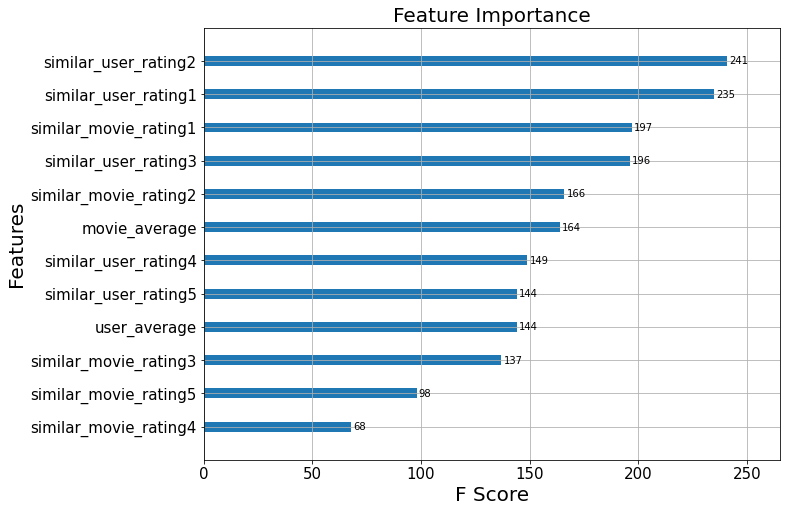

In [38]:
plot_importance(xgb, clf)

## References:
* How retailers can keep up with consumers, McKinsey & Company, https://www.mckinsey.com/industries/retail/our-insights/how-retailers-can-keep-up-with-consumers
* How Netflix’s Recommendation System Works, Netflix Research, https://help.netflix.com/en/node/100639
* Recommendations, Figuring out how to bring unique joy to each member, Netflix Research, https://research.netflix.com/research-area/recommendations
* Collaborative Filtering, University of Pittsburgh, Peter Brusilovsky, Sue Yeon and Danielle Lee, https://pitt.edu/~peterb/2480-122/CollaborativeFiltering.pdf